## Rebuild Of Research Presented by Vahe et al

#### Intro

#### Resources For Data Scraping
1. R
* * https://github.com/jkeirstead/scholar
* * https://cran.r-project.org/web/packages/easyPubMed/index.html
2. Python 
* * Official python app to download Elsevier data (Scopus, ScienceDirect)
https://github.com/ElsevierDev/elsapy
* * Scraper for Springer (2019) https://gist.github.com/rohitdwivedula/83f3d20b1f30b5fa02eecc0ab9ec2abd
* * Scraper for Springer & Scopus (2017) https://github.com/lanfeiliu/SpringerAPI-ElsevierAPI_LiteratureReviewTable
* * Scholarly GS scraper https://pypi.org/project/scholarly/
* * Official Google Scholar app: https://serpapi.com/blog/scrape-historic-google-scholar-results-using-python/

#### {mat2vec} Installation From Local Source

In [ ]:
! pip install -r requirements.txt

In [ ]:
! python setup.py install

In [ ]:
! pip install chemdataextractor

In [ ]:
! cde data download

#### {mat2vec} sample use cases

#### MaterialsTextProcessor
##### example 1: chemical entity extraction

In [8]:
from mat2vec.processing import MaterialsTextProcessor
text_processor = MaterialsTextProcessor()
text_processor.process("LiCoO2 is a battery cathode material.")

(['CoLiO2', 'is', 'a', 'battery', 'cathode', 'material', '.'],
 [('LiCoO2', 'CoLiO2')])

#### word2vec 
##### example 2: contextual similarity

In [9]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("mat2vec/training/models/pretrained_embeddings")
w2v_model.wv.most_similar("thermoelectric")

[('thermoelectrics', 0.8435686826705933),
 ('thermoelectric_properties', 0.8339031934738159),
 ('thermoelectric_power_generation', 0.7931368947029114),
 ('thermoelectric_figure_of_merit', 0.7916494011878967),
 ('seebeck_coefficient', 0.7753845453262329),
 ('thermoelectric_generators', 0.7641352415084839),
 ('figure_of_merit_ZT', 0.7587920427322388),
 ('thermoelectricity', 0.7515754699707031),
 ('Bi2Te3', 0.7480159997940063),
 ('thermoelectric_modules', 0.7434878945350647)]

##### example 2a: similarity - underscores used to query phrases

In [13]:
w2v_model.wv.most_similar("band_gap", topn=5)

[('bandgap', 0.9348015189170837),
 ('band_-_gap', 0.9334774613380432),
 ('band_gaps', 0.8606899380683899),
 ('direct_band_gap', 0.851127564907074),
 ('bandgaps', 0.818678617477417)]

##### example 3: identification/extraction of relations (analogies)

In [14]:
# helium is to He as ___ is to Fe? 
w2v_model.wv.most_similar(
    positive=["helium", "Fe"], 
    negative=["He"], topn=1)

[('iron', 0.7700884342193604)]

##### example 3a: analogies - using formula normalization

In [15]:
from mat2vec.processing import MaterialsTextProcessor
text_processor = MaterialsTextProcessor()
w2v_model.wv.most_similar(
    positive=["cubic", text_processor.normalized_formula("CdSe")], 
    negative=[text_processor.normalized_formula("GaAs")], topn=1)

[('hexagonal', 0.616279661655426)]

## Additional Notes / Next Steps

#### Determining whether there exist directions in the embedding space
We can determine whether there exist directions in the embedding space that correlate with elemental properties by fitting a linear regression to predict each property using embeddings as features. We test on the following 7 elemental properties: Mendeleev number, atomic weight, melting temperature, covalent radius, electronegativity, as well as row and column in the periodic table. Since there are 200 features but only around 100 elements, even a model as simple as linear regression will overfit. To avoid this, we reduce the dimensionality to 15 by applying PCA to the normalized word embeddings. The new features are linear combinations of the original 200 and explain 65% of the total variance. No model selection was performed and there are no hyper-parameters to optimize, therefore, no need for any test set. 

Embedding used as features in a predictive task. 

The following (7) properties were individully modelled for prediction, for each element: mendeleev number, atomic weight, melting temperature, covalent radius, electronegativity, as well as row and column in the periodic table.

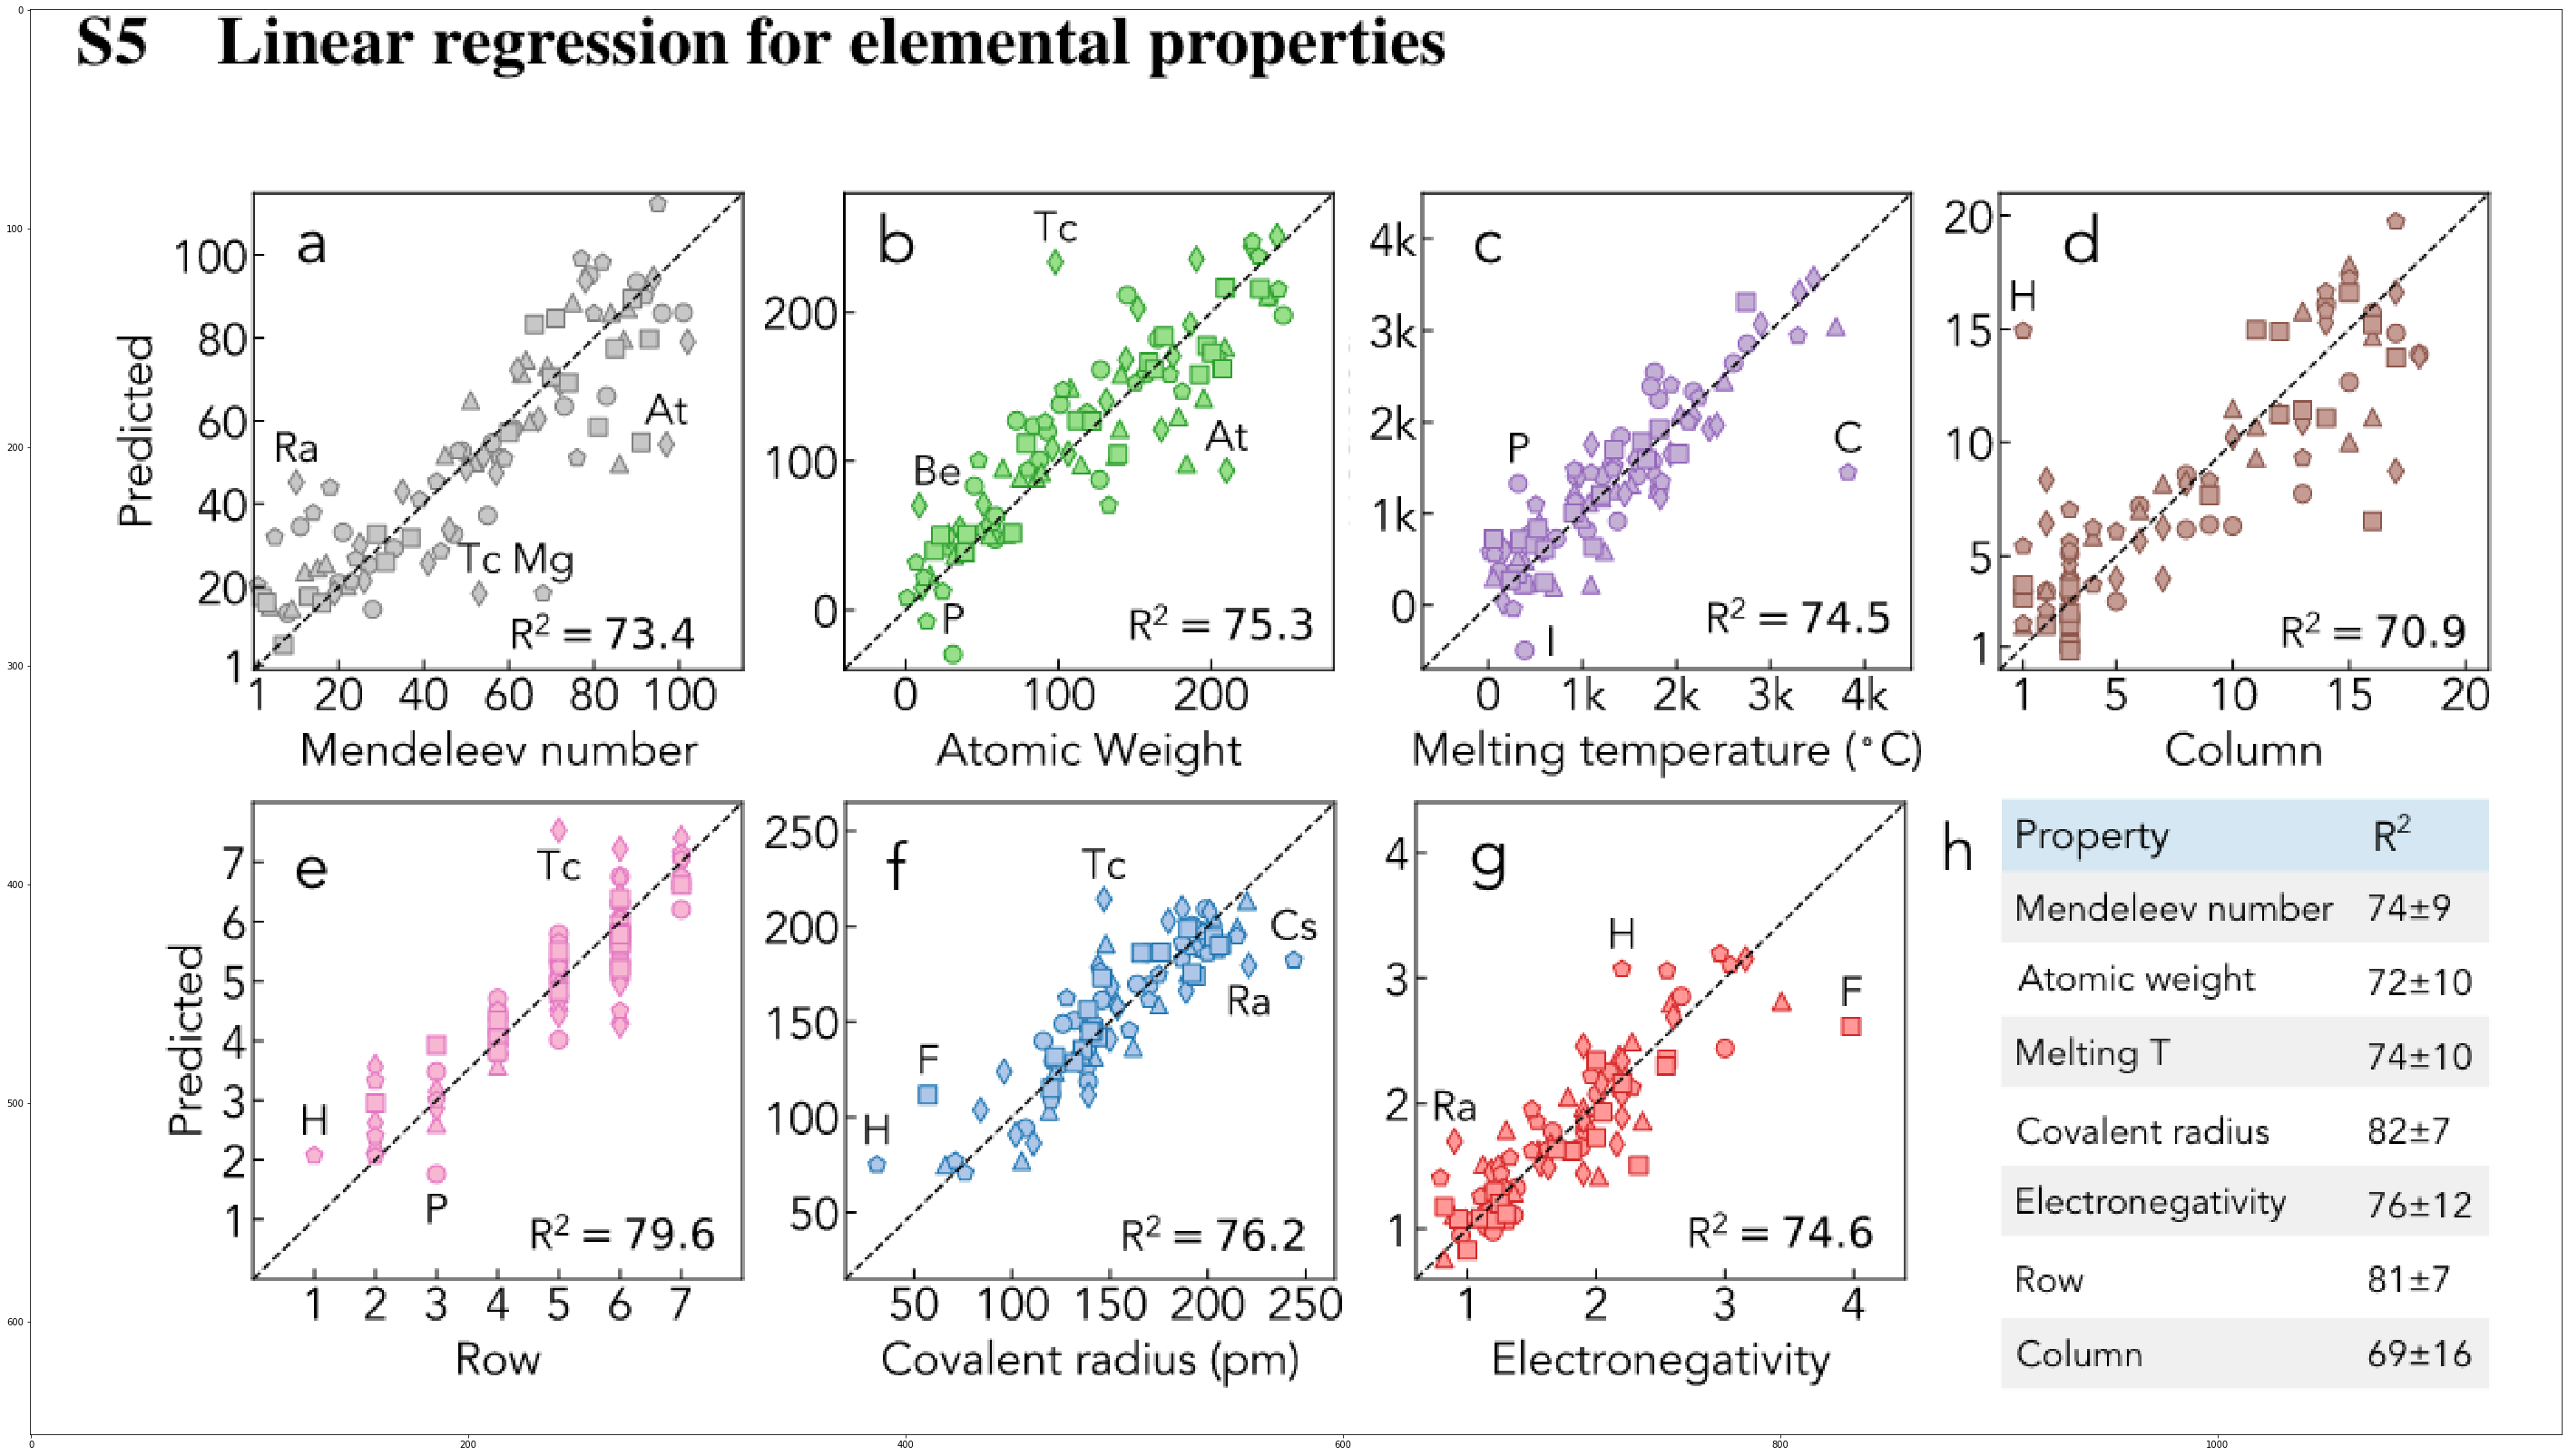

In [40]:
# plot outputs

import matplotlib.pyplot as plt
from matplotlib import image

fig = plt.figure(figsize=(50, 100))

img = image.imread("scratch/image01.png")
plt.imshow(img, interpolation='nearest')

plt.show()


Figure S5: Predictions of Elemental Properties. a-g. 5-fold cross-validated predictions of 7 elemental properties using linear regression. The first 15 principal components of word embeddings of element names (e.g. “hydrogen”) were used as features. The 5 different shapes indicate the exact cross-validation splitting, such that each shape (e.g. square) represents a set of validation elements predicted using the training elements represented by the 4 other shapes (e.g. triangles, diamonds, circles, pentagons). The splitting was determined randomly. h. Means and standard deviations of validation R2 scores (in percent) from 20 random 80% (training) / 20% (validation) splits.

#### PCA and alternatives

Authors used PCA to avoid problems of collinearity when applying a linear regression model. Despite a reduction in variability available to the model (only 65% of variability explained), predictive results ranged 70.9-79.6% R2 -- an unequivocally impressive result. An alternative approach that might be worthwhile includes analysis via XGB/XAI.

#### Material maps based on contextual similarities

Similar to chemical elements, one can visualize word embeddings of material formulas in 2D. Here, DBSCAN is used to generate similarity clusters with respect to a t-SNE projection of 12,340 word embeddings corresponding to materials mentioned at least 10 times in the corpus. Named material represents an exemplar for each cluster, as determined by PageRank, a web-ranking algorithm, in which items are ranked in terms of the degree of interconnectedness.

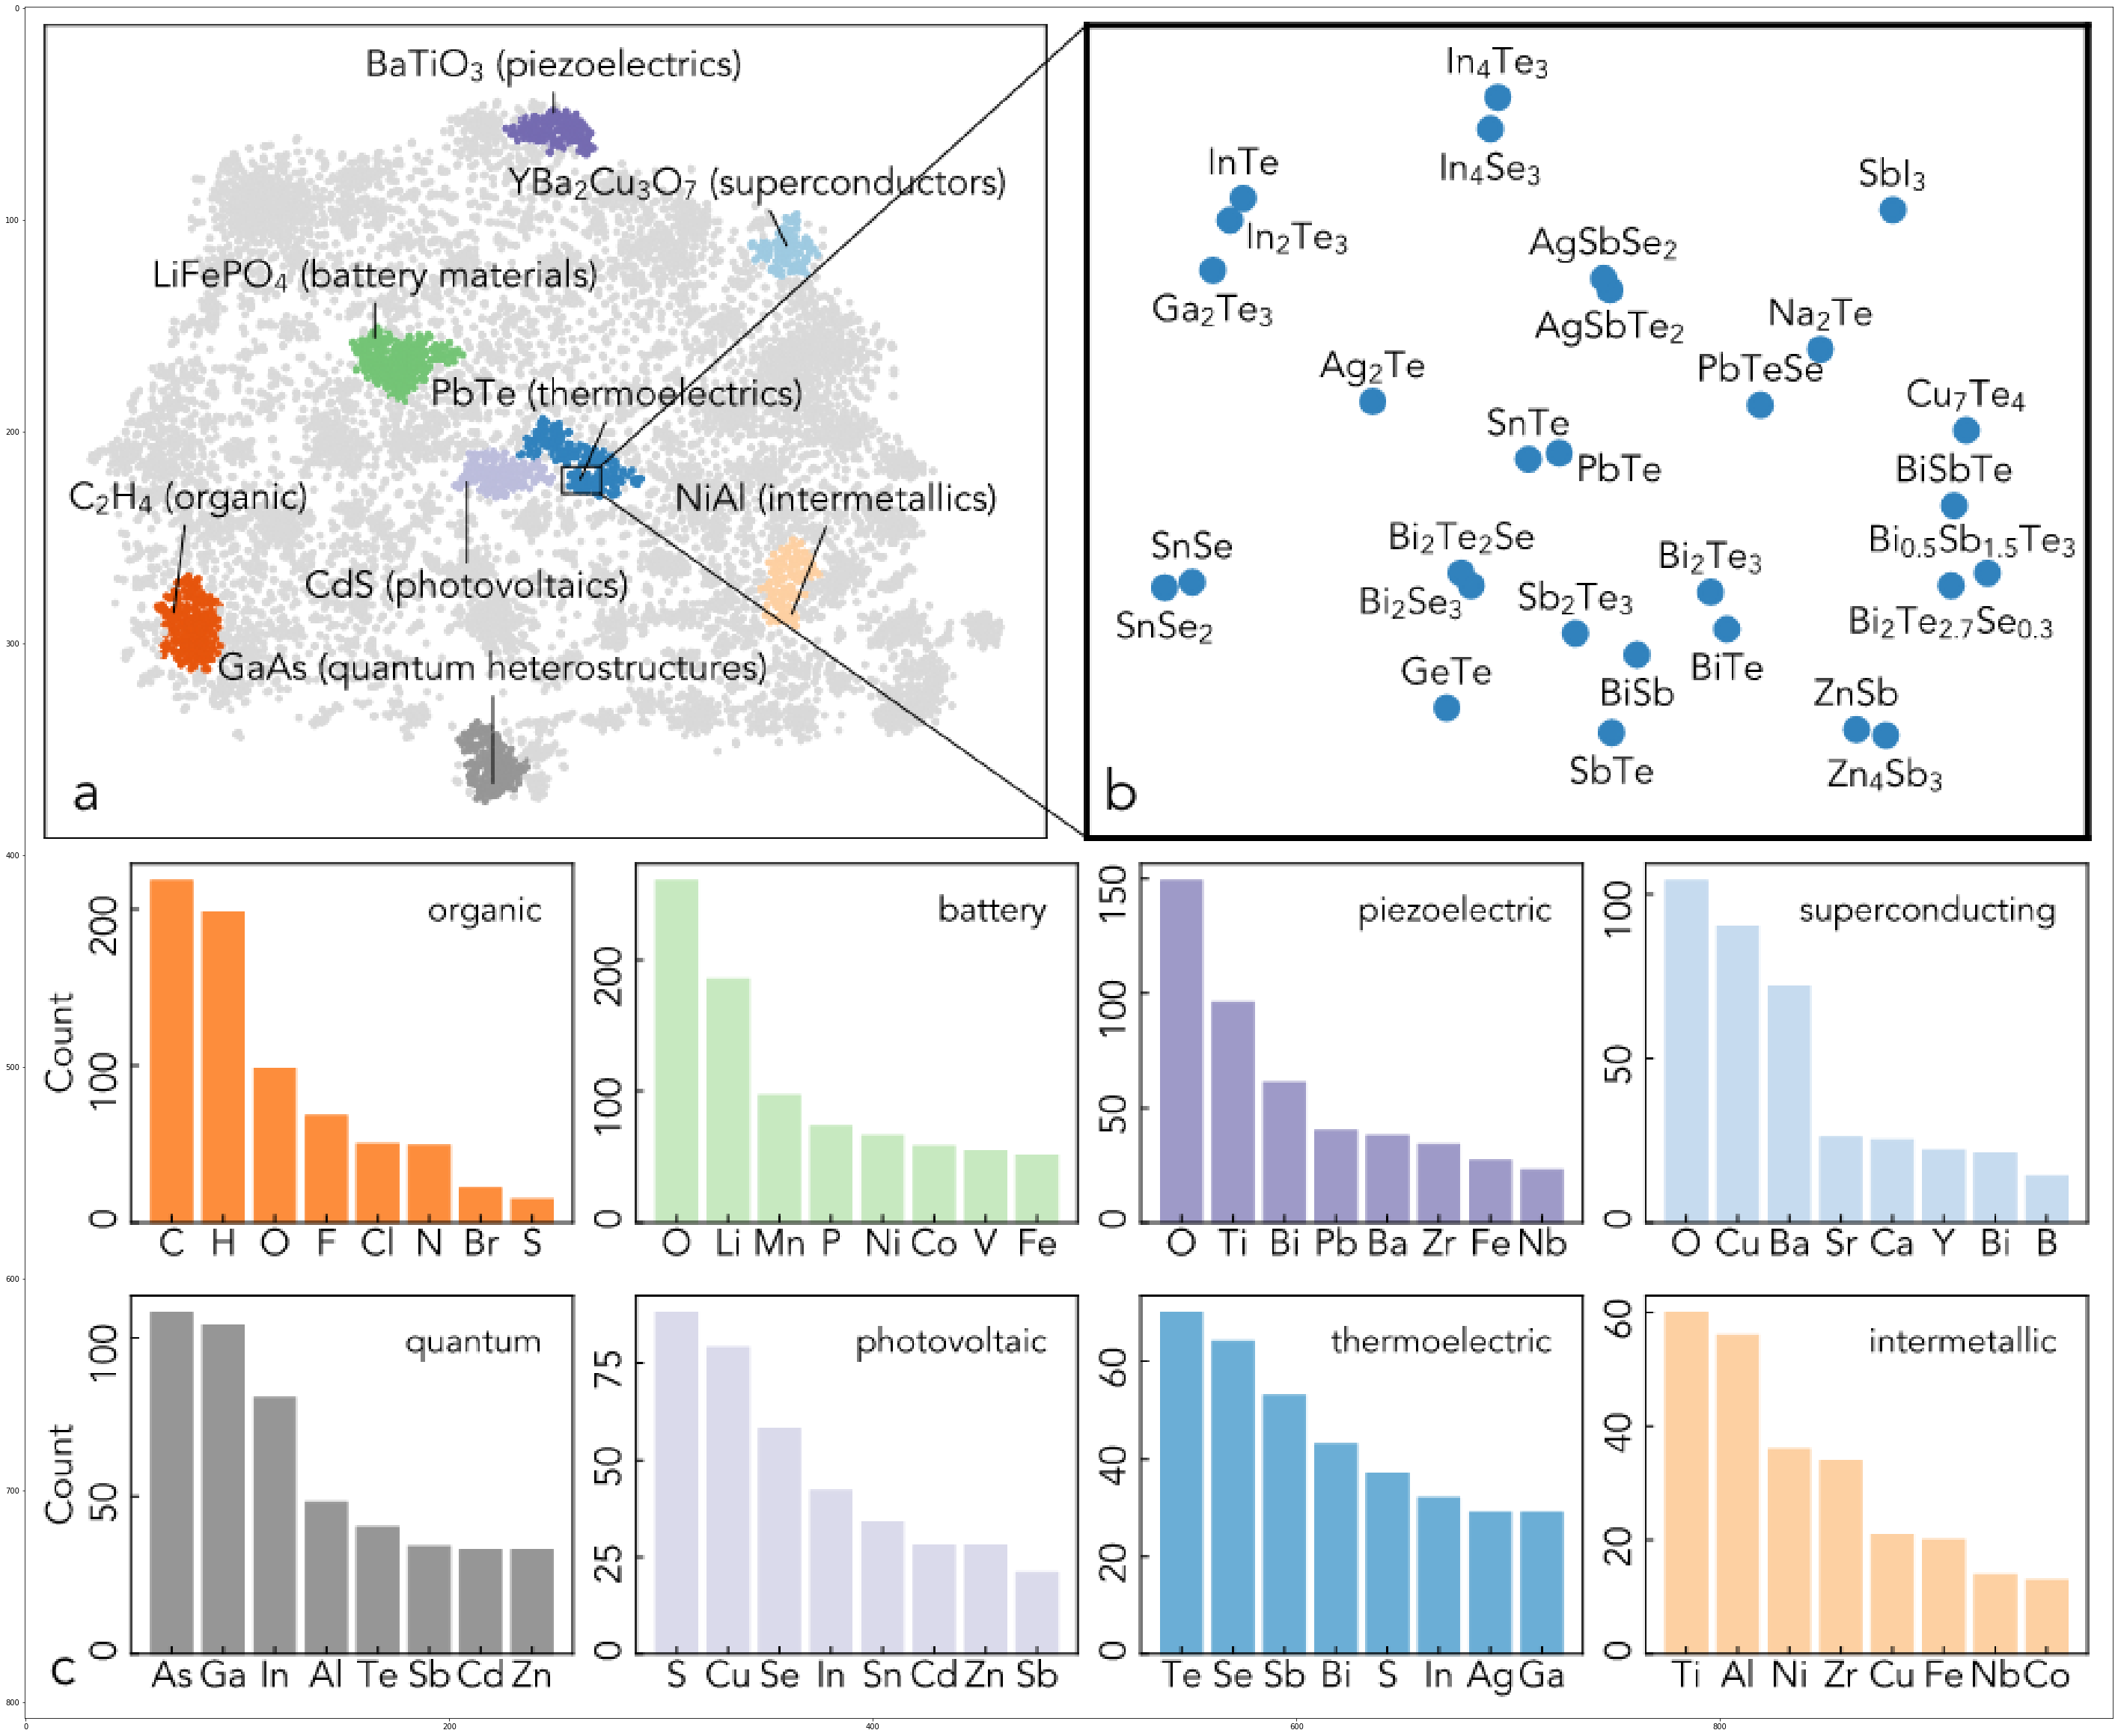

In [42]:
# plot outputs

import matplotlib.pyplot as plt
from matplotlib import image

fig = plt.figure(figsize=(50, 100))

img = image.imread("scratch/image02.png")
plt.imshow(img, interpolation='nearest')

plt.show()

Figure S7: Material maps. a. t-SNE projection of 12,340 word embeddings corresponding to materials mentioned at least 10 times in the corpus. Each point represents a unique stoichiometry. The relative distance of materials can be interpreted as their context-based similarity. The materials are clustered in an unsupervised manner using DBSCAN, which groups together high density areas. The labeled material in each cluster corresponds to the “most connected” material within that cluster. This is determined using PageRank within each cluster, with weights corresponding to cosine similarities of word embeddings. b. A region of the map in a. in the vicinity of PbTe – one of the most common thermoelectric materials. c. Counts of the eight most common elements from each cluster in a., counted one per material independent on their stoichiometric ratios.

#### Material maps based on target word affinity

Here, points on our t-SNE projection are colored according to similarity wrt context of a given keyword. For any given given keyword, cosine similarity is calculated based on the contextual embeddings and the resulitng score is applied.

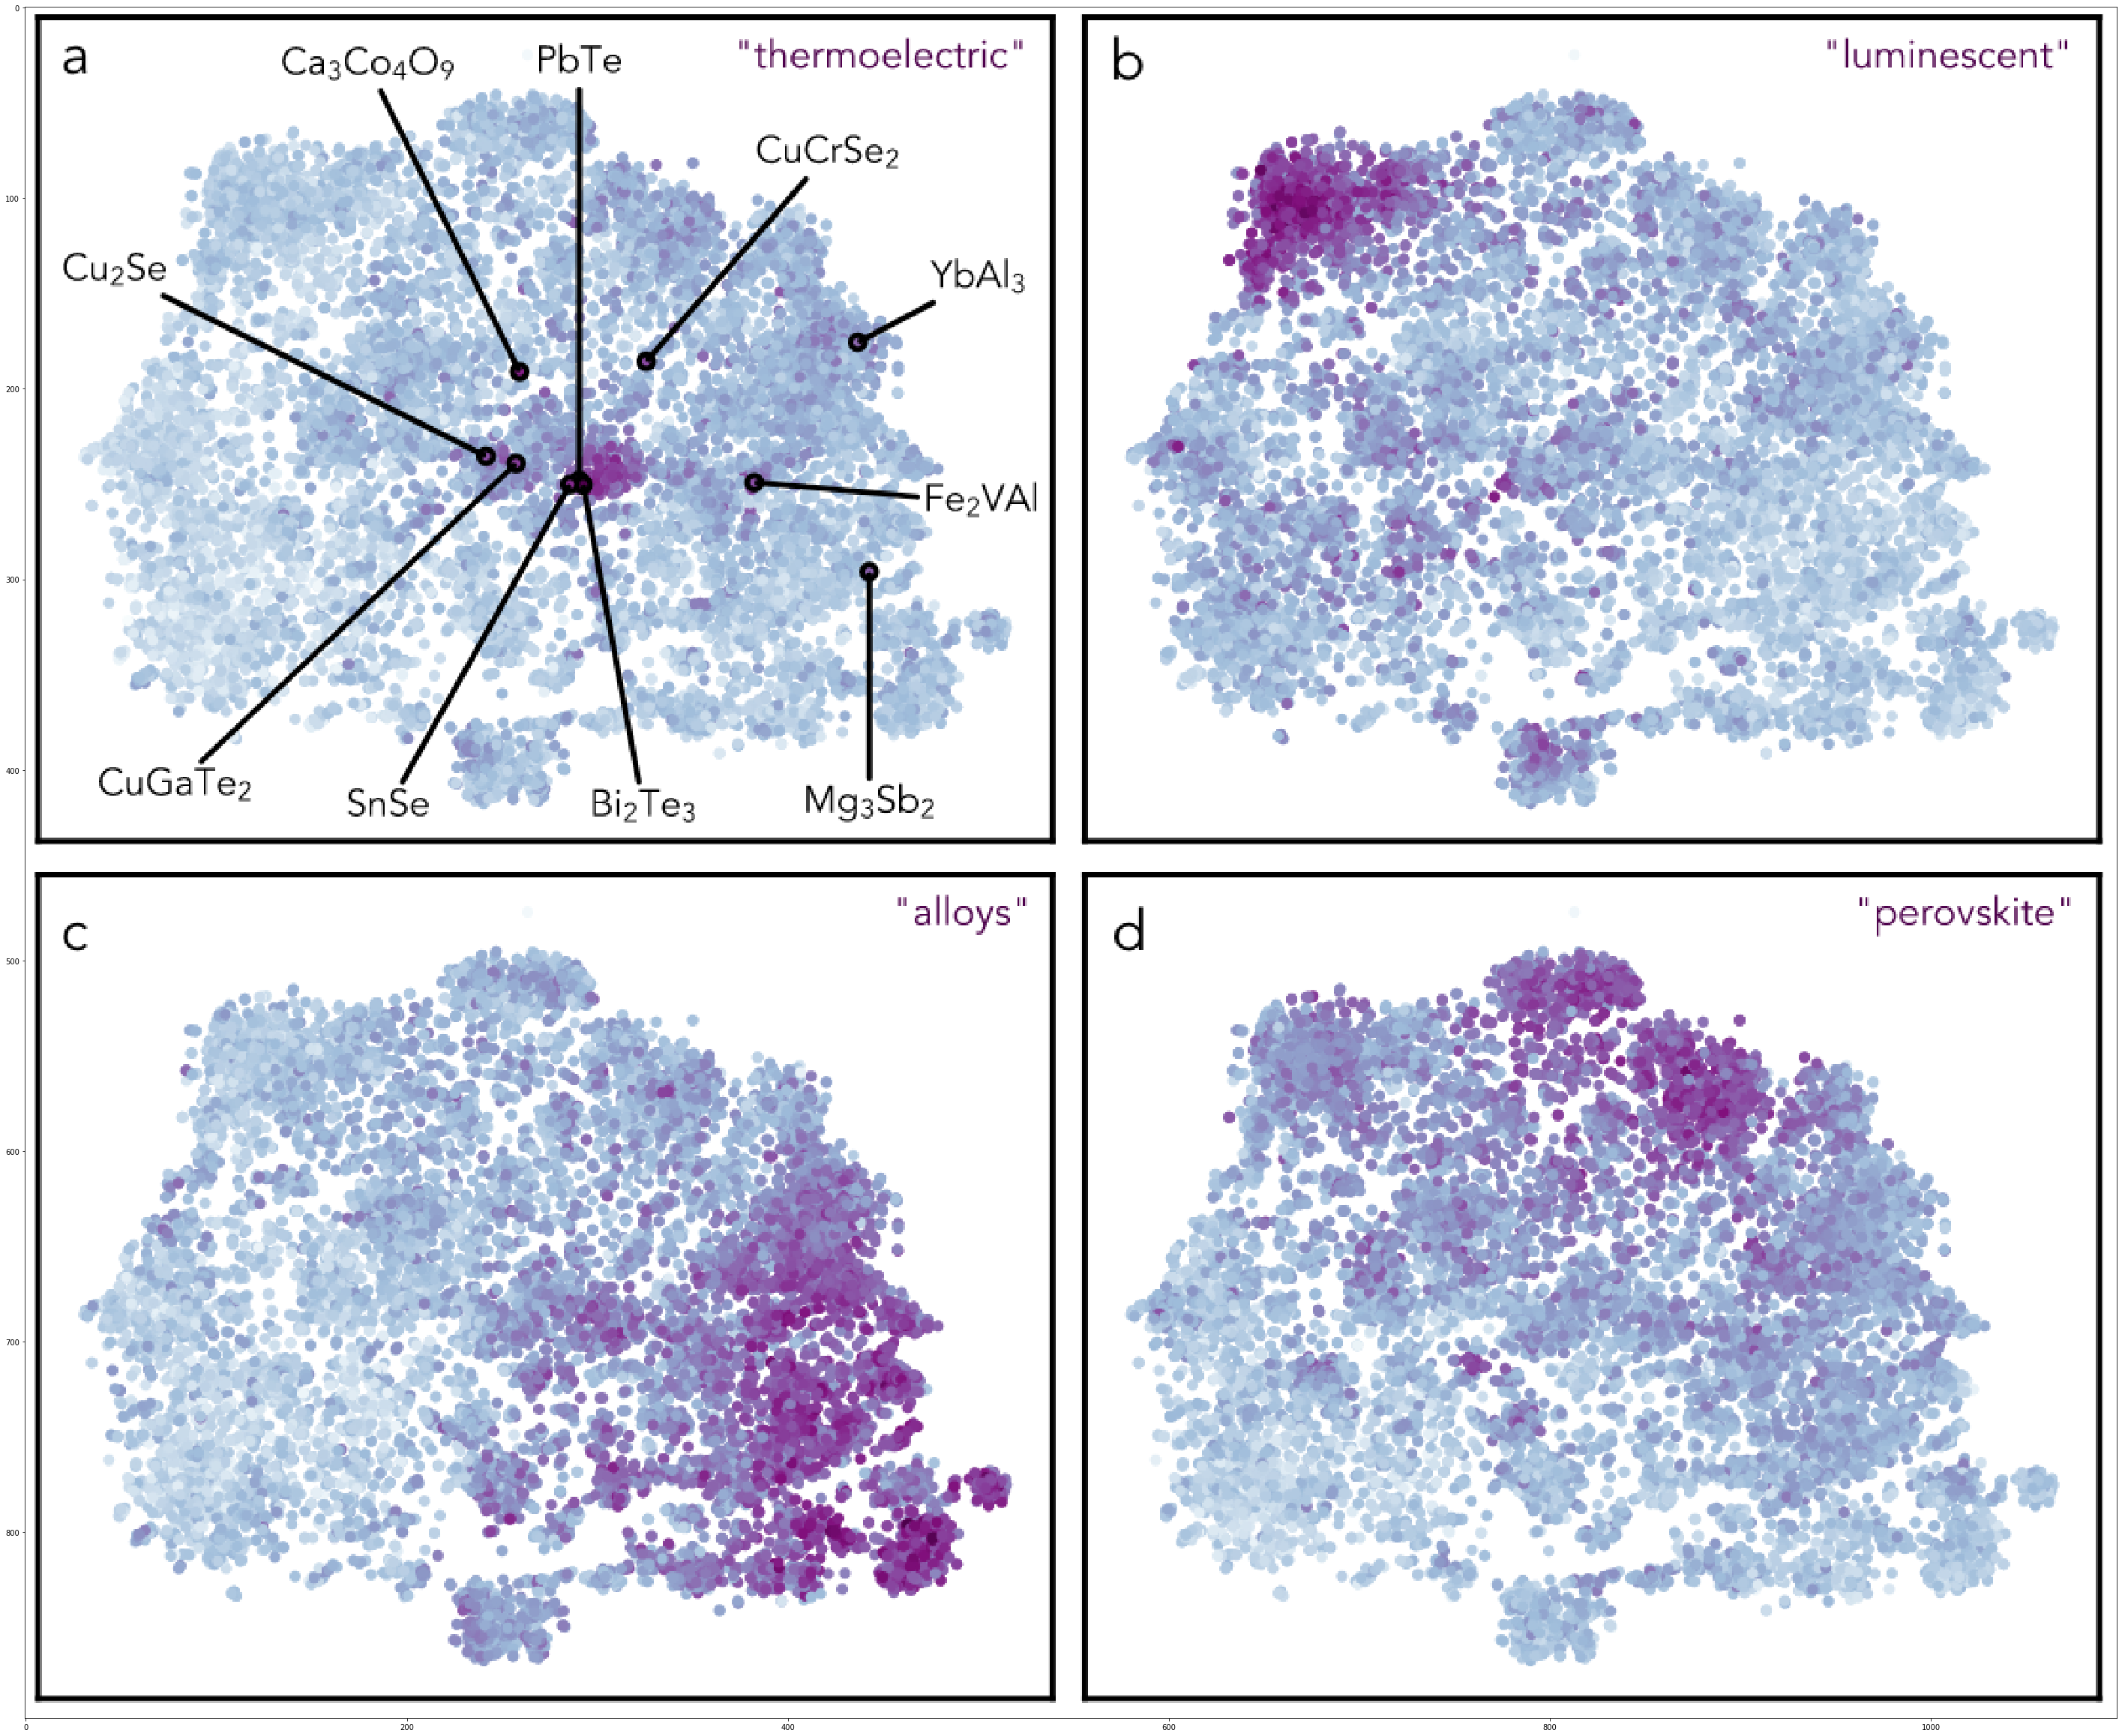

In [44]:
# plot outputs

import matplotlib.pyplot as plt
from matplotlib import image

fig = plt.figure(figsize=(50, 100))

img = image.imread("scratch/image03.png")
plt.imshow(img, interpolation='nearest')

plt.show()

## Sandbox

In [ ]:
from mat2vec.processing import MaterialsTextProcessor
text_processor = MaterialsTextProcessor()
text_processor.process("wettability , interfacial phenomena and shear strength for Al / O2Zr joining system driven by direct current we realized the wetting for molten Al on the <nUm> mol. % yttria - stabilized zirconia ( O2Zr ) with applying a direct current ( DC ) . the interfacial microstructures and shear stress were evaluated after wetting to reveal their native relationship with DC application . the results showed that not only the wettability of Al / O2Zr system but also the shear stress can be optimized by controlling the DC intensity and applying time , which strongly depends on the formation of Al3Zr at the interface of Al / O2Zr system . when the current intensity is <nUm> mA and applying time is <nUm> min , the shear stress reaches the maximum in our case . ")